# Ported code

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorspline as ts
from scipy import signal
from scipy import interpolate
from math import pi
from numpy import inf
import math
import time
import scipy.io as spio

In [2]:
%matplotlib inline

### Path to data

In [3]:
r_file_path = "D:\\MasterData\\TilEmil\\CarotidData\\12-Apr-2018\\13_34_57\\bf\\LowResBFdata_point1_1_r"
i_file_path = "D:\\MasterData\\TilEmil\\CarotidData\\12-Apr-2018\\13_34_57\\bf\\LowResBFdata_point1_1_i"

### Creating structs

In [4]:
bfPars =	{
    "f_demod": 4750000.0,
    "bandPassVec": np.array([2000000.0,2200000.0,7300000.0,7400000.0]),
    "c": 1540.0,
    "txVals": np.array([-0.2618,-0.2618,-0.2618,-0.2618,0.2618,0.2618,0.2618,0.2618,0.2618]),
    "rxVals": np.array([-0.2618,-0.0611,0.1047,0.2618,0,-0.1047,0.0611,0.2618,0]),
    "PRF": 6000,
    "lowResRxApodDop": 'hamming',
    "lowResRxApodBmode": 'hamming',
    "lowResRxFnumDop": 1.5,
    "lowResRxFnumBmode": 0.9,
    "nrEdgeSmoothingElementsDop": 20,
    "nrEdgeSmoothingElementsBmode": 20,
    "probe": 'GE9L-D',
    "x_axis": spio.loadmat("MatlabVariables/bfParsxAxis.mat")['bfParsXAxis'][:,0],
    "z_axis": spio.loadmat("MatlabVariables/bfParszAxis.mat")['bfParsZAxis'][:,0],
    "my_mask_x": 0,
    "my_mask_z": 0
}

class P:
    PRF = bfPars["PRF"]
    tx_vals = 1
    rx_vals = 1
    application = ""
    do_aliasing_correction = 0
    

# class Params:
#     a = 0
#     b = 10
    
    
# Params.a

# Not complete, need a way to fill the x_axis and z_axis, not sure what values are in there. Do we need it if it is just the data?

In [5]:
print(bfPars['x_axis'].shape)

(274,)


### Reading data, reshaping into a [184, 274, 9, 270] Matrix.

In [6]:
low_res_data_array = np.fromfile(r_file_path,np.float32,-1)+1j*np.fromfile(i_file_path,np.float32,-1)
low_res_data = low_res_data_array.reshape(184, 274, 9, 270,order='F')
print(low_res_data.shape)


(184, 274, 9, 270)


### Filling variables

In [7]:
nAngles = bfPars["rxVals"].size
# TODO: Find out if the index below is correct, in matlab it is 1-3
start_frame = 1 
end_frame = 3
num_saved_frames = end_frame - start_frame +1 # ???
application = 'carotid'

### Hack to look at data - find interesting frame


C:\Users\ebras\Anaconda3\envs\tensorflowP35\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


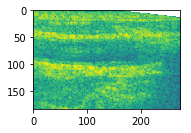

In [8]:
plt.subplot(2,1,1)
# TODO: Find out if parameters are correct
to_plot = 20*np.log10(np.absolute(np.squeeze(low_res_data[:,:,4,99])))
plt.imshow(to_plot)

#### Here it selects a frame for inspection, is this needed?

In [9]:
t_look = 1.2
t_start = start_frame*270/bfPars["PRF"] # 270 Hard coded for now
print(t_start)
t = t_look - t_start
print(t)
f_look = t*bfPars["PRF"]
print(f_look)

0.045
1.155
6930.0


### Sliding window, processing parameters

In [10]:
process_packet = 270
skip = 20

In [11]:
nr_lr_frames = low_res_data.shape[3]
# nr_lr_frames = 810 # For debugging

In [12]:
# The +1 at stop is not in matlab, but needed in python to get the same size
max_num_process_packets = np.arange(start=process_packet/2,stop=(nr_lr_frames-process_packet/2)+1, step=skip).size
print(max_num_process_packets)

1


In [13]:
# TODO: Find out if this should be 1, as it is in Matlab
start_packet = 0 

In [14]:
nr_packets = 1

There is created a struct in matlab with processPacket, skip and vdtime. Is this needed?

In [15]:
procParams = 	{
    "process_packet": process_packet,
    "skip": skip,
    # Removed -1 from max_num_process_packets
    "vd_time": (np.arange(start=process_packet/2, stop=skip*(max_num_process_packets)+(process_packet/2), step=skip)) / bfPars["PRF"]
}
print(procParams["vd_time"])
# ((processPacket/2):skip:skip*(maxNumProcessPackets-1)+(processPacket/2))/bfPars.PRF# 

[0.0225]


In [16]:
print(procParams["vd_time"].size)

1


In [17]:
filter_b_hc = np.array([0.013974507740562,  -0.004610553690858,  -0.003959583887660,  -0.003421437717813,  -0.002960559310507,  -0.002546987603092,  -0.002152407693477,  -0.001752369109738,  -0.001335666591534,  -0.000886985569956,
                    -0.000406397631234, 0.000105239633353, 0.000636228776527, 0.001171627782228, 0.001691442937575, 0.002171473383531, 0.002586613469418, 0.002909053988966,  0.003114143802294, 0.003178699822964, 0.003086226298184,
                     0.002825822207217, 0.002394929610520, 0.001799244313407, 0.001053101010350, 0.000180580071057, -0.000786262822472, -0.001805922295758, -0.002831500727849,-0.003809890804760,
                    -0.004687127561322, -0.005408537732333, -0.005923021230674, -0.006185023274673, -0.006155931408084, -0.005809908523186, -0.005131231888127, -0.004123857624046, -0.002803648953984, -0.001207644615326,
                     0.000614581185567, 0.002598863723559, 0.004660609482286, 0.006719040134487, 0.008639305794054, 0.010372033472662, 0.011759174363705, 0.012712332141398, 0.013147237722652, 0.012976492549904,
                     0.012124612380978, 0.010533980201414, 0.008197019674078, 0.005103604492666, 0.001282897291549, -0.003220624315483, -0.008330358995150, -0.013945505108362, -0.019943186225561, -0.026180338307836,
                    -0.032504133383748, -0.038751252020856, -0.044758360378768, -0.050362088368919, -0.055407601522240, -0.059751812084099, -0.063269556969409, -0.065858778396590, -0.067443137132184, 0.932023291287906,
                    -0.067443137132184, -0.065858778396590, -0.063269556969409, -0.059751812084099, -0.055407601522240, -0.050362088368919, -0.044758360378768, -0.038751252020856, -0.032504133383748, -0.026180338307836, 
                    -0.019943186225561, -0.013945505108362, -0.008330358995150, -0.003220624315483, 0.001282897291549, 0.005103604492666, 0.008197019674078, 0.010533980201414, 0.012124612380978, 0.012976492549904, 
                     0.013147237722652,  0.012712332141398,  0.011759174363705,  0.010372033472662, 0.008639305794054, 0.006719040134487, 0.004660609482286, 0.002598863723559, 0.000614581185567, -0.001207644615326,
                    -0.002803648953984, -0.004123857624046, -0.005131231888127, -0.005809908523186, -0.006155931408084, -0.006185023274673, -0.005923021230674, -0.005408537732333, -0.004687127561322, -0.003809890804760,
                    -0.002831500727849, -0.001805922295758, -0.000786262822472,  0.000180580071057, 0.001053101010350, 0.001799244313407,  0.002394929610520, 0.002825822207217, 0.003086226298184, 0.003178699822964,
                     0.003114143802294,  0.002909053988966, 0.002586613469418, 0.002171473383531,  0.001691442937575, 0.001171627782228, 0.000636228776527, 0.000105239633353, -0.000406397631234,-0.000886985569956,
                    -0.001335666591534, -0.001752369109738, -0.002152407693477, -0.002546987603092, -0.002960559310507, -0.003421437717813, -0.003959583887660, -0.004610553690858, 0.013974507740562])


filter_b = spio.loadmat('MatlabVariables/b_filter.mat')['b'][0]


### Instead of using different matrices (like in the matlab code), I use a dictonary of matrices.

In [18]:
R_mat_dict = {}
for x in range (1, 8):
    R_mat_dict["R{0}".format(x)] = np.zeros([184, 274])
    
print(R_mat_dict["R1"].shape)

(184, 274)


In [19]:
# What does fctr stand for? Frame Counter variable
fctr = 1
# TODO: Find out if for kk = 1:1:nrPackets only happens once, if so skip the loop
for kk in range(0,nr_packets):
    packet_data = low_res_data[:,:,:,process_packet*kk:(process_packet*kk)+process_packet]
    # Some settings
    show_compounded_frames = 0 # Figure displaying all "B-mode" frames??
    show_highpass_frames = 0   # Figure displaying all frames used for speckle tracking (after high pass filtering)
    use_median_filter = 1
    
    # Do you want the full aliasing correction procedure, or only simple least squares algorithm?
    do_aliasing_correction = 1
    
    if nr_packets < max_num_process_packets:
        save_for_movie = 0
    else:
        save_for_movie = 1
        print("Saving data for later use")
    
    # Beamforming parameters
    
    # Doppler ROI 
    use_max_ROI = 0 # If both options are 0, interactively chose ROI. (?)
    use_trapezoid_ROI = 1
    
    # TODO: There is a switch condition here, find out if this is needed. For now, only carotid will be implemented
    max_ROI_depth = 0.032
    min_ROI_depth = 0.005
    
    # Color Doppler/vector Doppler settings
    drop_samples = 1 # For R1 estimation, avoid clutter filter edge effects
    power_threshold_after_hp = 15 # TODO: Remove hard coding
    
    # Specle tracking options
    use_corr_threshold = 1
    correlation_threshold = 0.1
    
    # Angle vectors
    tx_angles = bfPars["txVals"]
    rx_angles = bfPars["rxVals"]
    
    # Filter specs
    pre_c_data = packet_data[:,:,rx_angles==0,:]
#     print(pre_c_data.shape)
#     matlab_pre_c = spio.loadmat('FinalMatlabVariables/preCData.mat')['preCData']
#     print((np.abs(pre_c_data - matlab_pre_c) > 0.001).sum())
    
    recons_comp_data = pre_c_data.sum(axis=2, dtype=complex) # This changes the shape to a 3D matrix, think it still works, but need further testing
    
    matlab_recons_comp_data = np.squeeze(spio.loadmat('FinalMatlabVariables/recons_comp_data.mat')['recons_comp_data'])
    print((np.abs(recons_comp_data - matlab_recons_comp_data) > 0.0001).sum())
    
    
    rem_inds = np.array([4,8]) # TODO: Remove hard coding
    tx_angles = np.delete(tx_angles, rem_inds)
    rx_angles = np.delete(rx_angles, rem_inds)
        
    l = list(range(9))
    del l[8],l[4]
    
    packet_data = packet_data[:,:,l]
    
    
    low_res_R0_hp_mat = np.zeros([packet_data.shape[0], packet_data.shape[1], rx_angles.size])
    for ii in range(0,rx_angles.size):
        squeezed_arr = np.squeeze(packet_data[:,:,ii,:]) # Not sure if this does what I want        
        transposed_arr = np.transpose(np.asfortranarray(squeezed_arr), (2,0,1))
        
        # Filtering
        filtered_arr = signal.lfilter(filter_b, 1, transposed_arr, axis=0)
        np.set_printoptions(linewidth=50,suppress=True)
        
        removed_arr = filtered_arr[filter_b.size-1:,:,:]
        temp = np.transpose(np.asfortranarray(removed_arr), (1,2,0))
        
        low_res_R0_hp_mat[:,:,ii] = np.mean(np.conj(temp)*temp, axis=2)
        
        # There is an eval statement in the Matlab code, ask about this
        R_mat_dict["R{0}".format(ii+1)] = np.mean(np.conj(temp[:,:,drop_samples:-2]) * temp[:,:,1+drop_samples:-1], axis=2)

Saving data for later use
0


C:\Users\ebras\Anaconda3\envs\tensorflowP35\lib\site-packages\ipykernel_launcher.py:76: ComplexWarning: Casting complex values to real discards the imaginary part


### Checking if the R1-R7 matrices match

In [20]:
matlab_R1 = spio.loadmat('MatlabVariables\\R1.mat')['R1']
print((np.abs(R_mat_dict["R1"]-matlab_R1)>0.001).sum())
matlab_R2 = spio.loadmat('MatlabVariables\\R2.mat')['R2']
print((np.abs(R_mat_dict["R2"]-matlab_R2)>0.001).sum())
matlab_R3 = spio.loadmat('MatlabVariables\\R3.mat')['R3']
print((np.abs(R_mat_dict["R3"]-matlab_R3)>0.001).sum())
matlab_R4 = spio.loadmat('MatlabVariables\\R4.mat')['R4']
print((np.abs(R_mat_dict["R4"]-matlab_R4)>0.001).sum())
matlab_R5 = spio.loadmat('MatlabVariables\\R5.mat')['R5']
print((np.abs(R_mat_dict["R5"]-matlab_R5)>0.001).sum())
matlab_R6 = spio.loadmat('MatlabVariables\\R6.mat')['R6']
print((np.abs(R_mat_dict["R6"]-matlab_R6)>0.001).sum())
matlab_R7 = spio.loadmat('MatlabVariables\\R7.mat')['R7']
print((np.abs(R_mat_dict["R7"]-matlab_R7)>0.001).sum())
matlab_LowResR0hpMat = spio.loadmat('FinalMatlabVariables/LowResR0hpMat.mat')['LowResR0hpMat']
print((np.abs(low_res_R0_hp_mat-matlab_LowResR0hpMat) > 0.001).sum())


0
0
0
0
0
0
0
0


### Clutter filter compounded data, this should be in the kk loop

In [21]:
matlab_recons_comp_data = spio.loadmat('FinalMatlabVariables/recons_comp_data.mat')['recons_comp_data']
print(matlab_recons_comp_data.shape)
matlab_recons_comp_data = np.squeeze(matlab_recons_comp_data)
print((np.abs(recons_comp_data - matlab_recons_comp_data) > 0.001).sum())

(184, 274, 1, 270)
0


In [22]:
print(recons_comp_data.shape)
transposed_arr2 = (np.transpose(np.asfortranarray(recons_comp_data), (2, 0, 1)))
print(transposed_arr2.shape)
matlab_squeezed_arr = spio.loadmat('FinalMatlabVariables/tmp.mat')['tmp']
print((np.abs(transposed_arr2 - matlab_squeezed_arr) > 0.001).sum())
print(np.mean(matlab_squeezed_arr))
print(np.mean(transposed_arr2))


(184, 274, 270)
(270, 184, 274)
0
(159.46902452104862+238.9963810976268j)
(159.46902452104888+238.99638109762697j)


In [23]:
iq_hp_comp = signal.lfilter(filter_b, 1, transposed_arr2, axis=0)

matlab_iq_hp_comp0 = spio.loadmat('MatlabVariables/iqhp0.mat')['iqhp']
print(matlab_iq_hp_comp0.shape)
print(np.mean(matlab_iq_hp_comp0))
print((np.abs(iq_hp_comp-matlab_iq_hp_comp0) > 0.001).sum())
iq_hp_comp = iq_hp_comp[filter_b.size-1:,:,:]
matlab_iq_hp = spio.loadmat('MatlabVariables/iqhp.mat')['iqhp']
print(iq_hp_comp.shape)
print(matlab_iq_hp.shape)
print((np.abs(iq_hp_comp-matlab_iq_hp) > 0.001).sum())
print(np.mean(iq_hp_comp))

(270, 184, 274)
(-0.024386472012334442-0.03573626472531036j)
0
(132, 184, 274)
(132, 184, 274)
0
(-0.025637316838837416-0.05466694314475268j)


In [24]:
iq_hp_comp = np.transpose( np.expand_dims(np.asfortranarray(iq_hp_comp), axis=3), (1,2,3,0) )
print(iq_hp_comp.shape)
matlab_iq_hp_comp = spio.loadmat('FinalMatlabVariables/iqhpComp.mat')['iqhpComp']
print((np.abs(iq_hp_comp - matlab_iq_hp_comp) > 0.01).sum())
print(np.mean(matlab_iq_hp_comp))

(184, 274, 1, 132)
0
(-0.025637316838839446-0.05466694314475234j)


In [25]:
max_iq_hp = np.max(np.abs(iq_hp_comp))
print(max_iq_hp)

266.5121282274633


In [26]:
max_iq = np.max(np.abs(recons_comp_data))
print(max_iq)

156859.58761609675


In [27]:
print(iq_hp_comp.shape)
r0_test = 10*np.log10((np.mean(np.abs(iq_hp_comp)**2,axis=3)))
r0_test = np.squeeze(r0_test)
print(r0_test.shape)
print(r0_test[0:10,0])

(184, 274, 1, 132)
(184, 274)
[ 6.39660037  5.52042926  5.98430473  8.40369592
 10.36452768 11.02899965 10.67641019 10.82401749
 11.57332919 10.73325998]


In [28]:
r0_mask = np.zeros(iq_hp_comp.shape[:2])
print(r0_mask.shape)

(184, 274)


In [29]:
print(power_threshold_after_hp)
print(r0_test.shape)
print(r0_mask.shape)
r0_mask = np.where(r0_test > power_threshold_after_hp, 1, 0)

15
(184, 274)
(184, 274)


In [30]:
r0_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [31]:
spio.loadmat('MatlabVariables\\R0Mask.mat').keys()
matlab_r0_mask = spio.loadmat('MatlabVariables\\R0Mask.mat')['R0Mask']
print(matlab_r0_mask.shape)

(184, 274)


In [32]:
# Make sure that this is enough, migth want a second opinion
print((r0_mask-matlab_r0_mask) !=  0)
np.abs(r0_mask-matlab_r0_mask).sum()



[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


0

### Not sure what getColormap does

In [33]:
r1_test = np.mean(np.conj(iq_hp_comp[:,:,:,drop_samples:-1]) * iq_hp_comp[:,:,:,1+drop_samples:],3 )
r1_test = np.squeeze(r1_test)
print(r1_test.shape)

(184, 274)


In [34]:
matlab_R1_test = spio.loadmat('FinalMatlabVariables/R1Test.mat')['R1Test']
print((np.abs(r1_test- matlab_R1_test) > 0.001).sum())

0


In [35]:
nx = 5
nz = 5
my_filter = np.ones([nz,nx])
n_thresh = 25
r0_mask_conv = signal.convolve2d(r0_mask,my_filter,mode='same')
print(r0_mask_conv.shape)

(184, 274)


In [36]:
# Checking if the R0MaskConv is the same as my python implementation
matlab_conv_mask = spio.loadmat('MatlabVariables\\R0MaskConv.mat')['R0MaskConv']
print(matlab_conv_mask.shape)
print((np.abs(r0_mask_conv-matlab_conv_mask)>0.1).sum())

(184, 274)
0


In [37]:
r0_mask_conv = np.where(r0_mask_conv < n_thresh, 0, 1)

In [38]:
matlab_conv_mask2 = spio.loadmat('MatlabVariables\\R0MaskConv2.mat')['R0MaskConv']
matlab_conv_mask2.shape
print((np.abs(r0_mask_conv-matlab_conv_mask2)>0.00001).sum())


0


In [39]:
r0_mask = r0_mask_conv
r1_conv = signal.convolve2d(r1_test,my_filter,mode='same')
r1_masked = r1_conv * r0_mask

In [40]:
r1_masked.shape

(184, 274)

In [41]:
matlab_r1_masked = spio.loadmat('MatlabVariables\\R1Masked.mat')['R1Masked']
matlab_r1_masked.shape
print((np.abs(r1_masked-matlab_r1_masked)>0.1).sum())

0


In [42]:
X,Z = np.meshgrid(bfPars["x_axis"], bfPars["z_axis"])

In [134]:
# Checking that the X and Z grids are the same
matlab_X = spio.loadmat('MatlabVariables\\X.mat')['X'].astype(float)
matlab_Z = spio.loadmat('MatlabVariables\\Z.mat')['Z'].astype(float)
print(matlab_X.shape)
print(matlab_Z.shape)
print(X.shape)
print(Z.shape)

print((np.abs(X-matlab_X)> (np.mean(matlab_X)/100)).sum())
# print((np.abs(Z-matlab_Z)>).sum())


(184, 274)
(184, 274)
(184, 274)
(184, 274)
50416


### Image showing section, insert here when all computations are done

In [44]:
if(use_trapezoid_ROI == 1):
    cfi_mask = np.ones(r0_mask.shape)
    print(cfi_mask.shape)

(184, 274)


In [45]:
cfi_mask_const = np.tan(np.max(np.abs(tx_angles)))
cfi_mask_length = cfi_mask.shape[1]
for zz in range(1,cfi_mask.shape[0]+1):
    n_zeros = np.ceil(zz*cfi_mask_const).astype(int)
    cfi_mask[zz-1,0:n_zeros] = 0
    cfi_mask[zz-1,cfi_mask_length-n_zeros:] = 0

In [46]:
print(cfi_mask.shape)
print(cfi_mask_const)
print(cfi_mask_const)
print(np.tan(np.max(np.abs(tx_angles))))

(184, 274)
0.26794984858612436
0.26794984858612436
0.26794984858612436


In [47]:
# Checking if the cfi mask is the same as in matlab
matlab_cfi_mask = spio.loadmat('MatlabVariables\\cfiMask.mat')['cfiMask'].astype(float)
print((np.abs(cfi_mask-matlab_cfi_mask)> 0.0001 ).sum())

0


In [48]:
# Step after the zz for loop in matlab
cfi_mask = np.where(Z < min_ROI_depth, 0, cfi_mask)

In [49]:
matlab_cfi_mask2 = spio.loadmat('MatlabVariables\\cfiMask2.mat')['cfiMask'].astype(float)
print((np.abs(cfi_mask-matlab_cfi_mask2)> 0.0001 ).sum())


0


In [50]:
r0_mask = r0_mask * cfi_mask

In [51]:
# Checking that r0_mask is the same as in matlab
matlab_r0_mask2 = spio.loadmat('MatlabVariables\\R0Mask2.mat')['R0Mask']
print((np.abs(r0_mask-matlab_r0_mask2) > 0.001).sum())

0


### Make Matrix of Doppler data from given tx-rx pattern

In [52]:
# TODO: Remove hard coding, find out where R1 comes from
r1_multi = np.zeros([184, 274, tx_angles.shape[0]]) * 1j
# r1_multi = r1_multi *1j
for rr in range(0, tx_angles.shape[0]):
    # TODO Find out eval(sprintf()) in matlab does
    r1_multi[:,:,rr] = R_mat_dict["R{0}".format(rr+1)]


In [53]:
matlab_r1_multi = spio.loadmat('MatlabVariables\\R1Multi.mat')['R1Multi']
print((np.abs(r1_multi-matlab_r1_multi) > 0.001).sum())

0


In [54]:
# Don't think mymask = R0Mask is necessary
my_mask = r0_mask
# Declaring r1_mat here, make sure that this is correct according to the matlab R1Mat
r1_mat = np.zeros([184,274,7])
r1_mat = r1_mat + 0j
print(r1_multi.shape)
for aa in range(1,tx_angles.shape[0]+1):
    temp = r1_multi[:,:,aa-1]
    r1_mat[:,:,aa-1] = temp * r0_mask

(184, 274, 7)


### Checking if the R1Mat matches the r1_mat

In [55]:
matlab_r1_mat = spio.loadmat('MatlabVariables\\R1Mat.mat')['R1Mat']
print((np.abs(r1_mat-matlab_r1_mat) > 0.001).sum())


0


In [56]:
nx = 7
nz = 7
my_filter = (1.0/float(nx*nz) * np.ones([nx, nz]))
matlab_filt = spio.loadmat('FinalMatlabVariables/filt.mat')['myFilt']
print((np.abs(my_filter - matlab_filt) > 0.0001).sum())

0


### Spatial averaging

In [57]:
r1_conv = np.resize(np.expand_dims(r1_conv,2),[184,274,7])
for aa in range(0, tx_angles.size):
    r1_conv[:,:,aa] = signal.convolve2d(r1_mat[:,:,aa],my_filter,mode='same')
    

In [58]:
matlab_r1_conv = spio.loadmat('MatlabVariables\\R1Conv.mat')['R1Conv']
print((np.abs(r1_conv-matlab_r1_conv) > 0.00000000001).sum())

0


In [59]:
# Don't think we need to do R1Convorig = R1Conv, but I'll do it for now
r1_conv_orig = r1_conv

### Vector Doppler Estimation

In [60]:
matlab_r1_conv_orig = spio.loadmat('MatlabVariables\\R1ConvOrig.mat')['R1ConvOrig']
print((np.abs(r1_conv_orig-matlab_r1_conv_orig) > 0.0001).sum())

0


In [61]:
r0_conv = np.zeros([np.where(my_mask == 1)[0].size, tx_angles.size])
print(r0_conv.shape)

(24355, 7)


In [62]:
temp_r1_conv = np.ones([24355,7])
temp_r1_conv = temp_r1_conv*1j
for angle_nr in range(0, tx_angles.size):
    r1_temp = r1_conv_orig[:,:,angle_nr]
    r1_temp = r1_temp.flatten(order='F')
    r1_temp_masked = r1_temp[my_mask.flatten(order='F') == 1]
    temp_r1_conv[:, angle_nr] = r1_temp_masked
    print(temp_r1_conv.shape)

(24355, 7)
(24355, 7)
(24355, 7)
(24355, 7)
(24355, 7)
(24355, 7)
(24355, 7)


### Checking if the R1Conv matrix matches after anglenr loop

In [63]:
matlab_r1_conv2 = spio.loadmat('MatlabVariables\\R1Conv2.mat')['R1Conv']
print((abs(temp_r1_conv-matlab_r1_conv2) > 0.00001).sum())

0


In [64]:
# Reshaping r1_mat
r1_mat = np.reshape(temp_r1_conv,[1, temp_r1_conv.shape[0], temp_r1_conv.shape[1]])

### Checking if the R1Mat still matches after reshaping

In [65]:
matlab_r1_mat2 = spio.loadmat('MatlabVariables\\R1Mat2.mat')['R1Mat']
print((abs(r1_mat-matlab_r1_mat2) > 0.001).sum())

0


In [66]:
# TODO: Find out what P stands for
p = P()

In [67]:
p.PRF = bfPars["PRF"]
p.tx_vals = tx_angles
p.rx_vals = rx_angles
p.application = application
p.do_aliasing_correction = do_aliasing_correction

In [68]:
print(p.tx_vals)
print(p.rx_vals)
print(p.application)
print(p.do_aliasing_correction)

[-0.2618 -0.2618 -0.2618 -0.2618  0.2618  0.2618
  0.2618]
[-0.2618 -0.0611  0.1047  0.2618 -0.1047  0.0611
  0.2618]
carotid
1


### Definition of dec2baseJorg()

In [69]:
def dec2baseJorg(index, new_base):
    ind_copy = index
    finished = False
    tmp = np.log(index)
    if tmp == -inf:
        tmp = 0
    out_vec = np.zeros([1, int(np.floor(np.round((tmp/np.log(new_base))+1,4)))])
    ctr = 1
    while not finished:
        out_vec[0, ctr-1] = np.mod(ind_copy,new_base)
        ind_copy = (ind_copy-out_vec[0, ctr-1]) / new_base
        if ind_copy == 0:
            finished = True
            break
        ctr = ctr + 1
    out_vec = np.fliplr(out_vec)
    return out_vec

In [70]:
tmp = np.zeros([1, int(np.floor(np.log(2286)/np.log(3))+1)])
tmp[0] = np.mod(0, 3)
vec = dec2baseJorg(3,3)
# print(np.floor(np.log(243)/np.log(3)) + 1)
# print(np.round((np.log(242)/np.log(3))+1,3))
tail = dec2baseJorg(218,3)
print(tail)

[[2. 2. 0. 0. 2.]]


### Definition of vectorDoppler()

In [71]:
def vectorDoppler(r1_mat, p):
    ''' Currently, the function doesn't return a valid minRes, see no point as it is not used further.
    '''
    # Skip the GPU stuff for now
    
    # Selecting alias limit, this is not all the same, find out what needs to be there
    if p.do_aliasing_correction == 1:
        if p.application == 'carotid':
            alias_limit = 3
        elif p.application == 'neo':
            alias_limit = 3
    else:
        alias_limit = 1
    
    r1_size = r1_mat.shape
    rx_angles = p.rx_vals
    tx_angles = p.tx_vals
    
    temp_angle = np.angle(r1_mat)
    
    f_mat = np.transpose(np.reshape(np.angle(r1_mat), [r1_mat.shape[0] * r1_mat.shape[1], r1_mat.shape[2]]) * p.PRF/(float(2*pi)))
    
    
    # Must be a better way to do this
    a_mat = np.divide(np.array([-np.sin(tx_angles)-np.sin(rx_angles), np.cos(tx_angles)+np.cos(rx_angles)]),2)
    a_mat = np.swapaxes(a_mat, 1, 0)
    pseudo_inv = np.linalg.pinv(a_mat)
    
    n_angles = r1_size[2]
    
    # where is nargin set?
    nargin = 0
    if nargin < 3:
        n_cases = alias_limit ** n_angles
        alias_mat = np.zeros([n_angles, n_cases])
        for pattern_code in range(0, n_cases):
            pattern = np.zeros([n_angles,1])
            tail = dec2baseJorg(pattern_code, alias_limit)
            pattern[-tail.shape[1]:,0] = tail
            alias_mat[:, pattern_code] = pattern[:,0]

    alias_mat = alias_mat[:,~np.all(alias_mat, axis=0)]
    
    n_cases = alias_mat.shape[1]
    n_points = f_mat.shape[1]
    
    g_res = np.transpose(np.dot(np.dot(a_mat, pseudo_inv) - np.identity(n_angles), np.dot(alias_mat, p.PRF)))
    f_res = np.dot(np.dot(a_mat, pseudo_inv)-np.identity(n_angles), f_mat)
    
    temp = np.zeros([n_cases, r1_mat.shape[0]*r1_mat.shape[1]])
    print(temp.shape)
    
    # There is a GPU part here, implement when finished with CPU
    
    print("f_res.shape = {0}".format(f_res.shape))
    print("g_res.shape = {0}".format(g_res.shape))
#     temp_f = np.matlib.repmat(f_res[0,:],2059,1)
#     print("temp_f.shape = {0}".format(temp_f.shape))
    
    # Works, but requires a lot of memory
    #print(np.sum((f_res[None]+g_res[...,None])**2,axis=1).shape)
    
    
    for i in range (0, n_angles):
        t = (f_res[None,i] + g_res[:,i,None])**2
        temp += t
        
    
    # Think this is correct, alias pattern will look different due to the indexing difference
    min_res = np.min(temp,axis=0)
    alias_pattern = np.argmin(temp, axis=0)

    vector_est = np.transpose(np.dot(pseudo_inv,(f_mat + (np.dot(alias_mat[:,alias_pattern], p.PRF)))))
    print("vector_est.shape = {0}".format(vector_est.shape))

    
    
    return vector_est, alias_pattern, alias_mat, min_res
    

In [72]:
# What does tic do?
vector_est, alias_pattern, alias_mat, min_res = vectorDoppler(r1_mat, p)

(2059, 24355)
f_res.shape = (7, 24355)
g_res.shape = (2059, 7)


C:\Users\ebras\Anaconda3\envs\tensorflowP35\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


vector_est.shape = (24355, 2)


### Checking if the variables returned from vectorDoppler() matches Matlab version

In [73]:
matlab_vector_est = spio.loadmat('MatlabVariables/vectorEst2.mat')['vectorEst']
print("vector_est difference = {0}".format((abs(vector_est-matlab_vector_est) > 0.1).sum()))

matlab_alias_pattern = spio.loadmat('MatlabVariables/aliasPat.mat')['aliasPat']
# Because of indexing difference
matlab_alias_pattern = matlab_alias_pattern - 1
print("alias_pattern difference = {0}".format((abs(alias_pattern-matlab_alias_pattern) > 0.01).sum()))

matlab_alias_mat = spio.loadmat('MatlabVariables/aliasMat2.mat')['aliasMat']
print("alias_mat difference = {0}".format((abs(alias_mat-matlab_alias_mat) > 0.01).sum()))

matlab_min_res = spio.loadmat('MatlabVariables/minRes.mat')['minRes']
print(np.mean(matlab_min_res))
print("min_res difference = {0}".format((abs(min_res-matlab_min_res) > 100).sum()))
# Find out if the min res difference matters

vector_est difference = 0
alias_pattern difference = 0
alias_mat difference = 0
105060.24370070045
min_res difference = 404


### Resolving ambiguities

In [131]:
dx = bfPars["x_axis"][1] - bfPars["x_axis"][0]
dz = bfPars["z_axis"][1] - bfPars["z_axis"][0]

# They look fairly similar, but their difference might be a problem

my_mask_x = X[my_mask == 1]
my_mask_z = Z[my_mask == 1]
matlab_mask_x = np.squeeze(spio.loadmat('FinalMatlabVariables/bf_pars_mask_x.mat')['bf_pars_mask_x'])
matlab_mask_z = np.squeeze(spio.loadmat('FinalMatlabVariables/bf_pars_mask_z.mat')['bf_pars_mask_z'])



print(matlab_mask_x[0:10])
print(my_mask_x[0:10])

bfPars["my_mask_x"] = my_mask_x
bfPars["my_mask_z"] = my_mask_z



-1.585529549607491e-19
[-0.01978669 -0.01978669 -0.01978669 -0.01978669
 -0.01978669 -0.01978669 -0.01978669 -0.01962647
 -0.01962647 -0.01946626]
[-0.01978669 -0.01962647 -0.01946626 -0.01930604
 -0.01914583 -0.01898561  0.00873178  0.00889199
  0.00905221  0.00921243]


### mediannan() definition

In [75]:
import sys # Todo remove this next time the jupyter kernel is loaded
def mediannan(A, sz):
    # "nargin" used as variable for if statement, ask what that is
    if np.size(sz) == 1:
        sz = np.array([sz, sz])
    
    if np.any(np.mod(sz,2) == 0):
        print("Error occurred, kernels size sz must be odd")
        sys.exit()
    
    margin = (sz-1) / 2
    AA = np.zeros((A.shape+2*margin.astype(int)))
    AA.fill(np.nan)
    AA[margin[0].astype(int):-margin[0].astype(int), margin[1].astype(int):-margin[1].astype(int)] = A
    
    
    ib, jb = np.mgrid[1:sz[0]+1, 1:sz[1]+1]
    i_s = ib + (jb-1)*AA.shape[0] # This does the same as matlab's sub2ind() 

    
    
    ia, ja = np.mgrid[1:A.shape[0]+1,1:A.shape[1]+1]
    ia = ia + (ja-1)*AA.shape[0]

    ia_flat = ia.flatten(order='F')
    i_s_flat = i_s.flatten(order='F')
    i_s_flat = i_s_flat-1
       
    id_x = np.matlib.repmat(ia_flat, i_s.size, 1) + np.transpose(np.matlib.repmat(i_s_flat, ia.size, 1))
    
    id_x = id_x -1
    tmp_AA = AA.flatten(order='F')
    b = np.sort(tmp_AA[id_x], axis=0)
    j = np.any(np.isnan(b),axis=0).astype(int)
    last = np.zeros([1, b.shape[1]]) + b.shape[0]
    last = np.squeeze(last)

    b_nan = np.isnan(b[:, j == 1]).astype(int)
    trash, last[j == 1] = b_nan.max(0), b_nan.argmax(0)

    matlab_last = spio.loadmat('MatlabVariables/last.mat')['last'][0]
    matlab_last = matlab_last -1
    
    # In matlab, all values in last[j] are subracted with 1, not sure if this is needed in python
    M = np.zeros([b.shape[1]])
    M.fill(np.nan)
    
    A_flat = A.flatten(order='F')

    valid = np.argwhere(~np.isnan(A_flat))
    valid = np.squeeze(valid)
    mid = (last[valid.astype(int)] + 1) / 2
    i1 = (np.floor(mid)) + ((valid)*b.shape[0]) # If (valid -1 ) is used, then the results differ from matlab, because of valid being indicies
    i2 = (np.ceil(mid)) + ((valid)*b.shape[0])

    b_flat = b.flatten(order='F')    
    M[valid.astype(int)] = 0.5*(b_flat[i1.astype(int)-1] + b_flat[i2.astype(int)-1])    
    M = np.reshape(M, A.shape, order='F')
        
    return M

### definition of blockMatching_noGPU()

In [76]:
# def blockMatching_noGPU(iq_hp_comp, v_cand, alias_mat, alias_pattern, bfPars, npx):
#     # Temporary fill in order to return 
#     final_est = 0
#     corr_val_tot = 0
#     chosen_alias_pattern = 0
    
#     print("iq_hp_comp.shape = {0}".format(iq_hp_comp.shape))
#     print("v_cand.shape = {0}".format(v_cand.shape))
#     print("alias_mat.shape = {0}".format(alias_mat.shape))
#     print("alias_pattern.shape = {0}".format(alias_pattern.shape))
#     print("npx = {0}".format(npx))

#     # Begins here
#     low_res_packet_size = iq_hp_comp.shape[3]
#     kernel_size = np.array([npx, npx], dtype=float)
#     dx = bfPars["x_axis"][1] - bfPars["x_axis"][0]
#     dz = bfPars["z_axis"][1] - bfPars["z_axis"][0]
#     n_points = v_cand.shape[1]
#     corr_val = np.zeros([v_cand.shape[2], n_points, low_res_packet_size-1])
#     g_axis_x = bfPars["x_axis"]
#     g_axis_z = bfPars["z_axis"]

#     coords_orig_x = np.linspace(start=-((kernel_size[0]-1)/2)*dx, stop=((kernel_size[0]-1)/2)*dx, num=kernel_size[0]) # The step might need altercation, but I think this will work
#     coords_orig_z = np.linspace(start=-((kernel_size[1]-1)/2)*dz, stop=((kernel_size[1]-1)/2)*dz, num=kernel_size[1]) # The step might need altercation, but I think this will work
#     o_xb, o_zb = np.meshgrid(coords_orig_x, coords_orig_z)
#     tmp = np.tile(o_xb, (1, n_points))
#     o_x = np.tile(o_xb, (1, n_points)) + np.reshape(np.tile(np.transpose(bfPars["my_mask_x"][0:n_points]), (int(kernel_size[0]*kernel_size[1]), 1)), [int(kernel_size[0]), int(kernel_size[1]*n_points)]) 
#     o_z = np.tile(o_zb, (1, n_points)) + np.reshape(np.tile(np.transpose(bfPars["my_mask_z"][0:n_points]), (int(kernel_size[0]*kernel_size[1]), 1)), [int(kernel_size[0]), int(kernel_size[1]*n_points)]) 
#     matlab_o_x = spio.loadmat('MatlabVariables/oX.mat')['oX']

#     # For tensorspline
# #     iq_hp_comp = iq_hp_comp[..., None]
# #     print(iq_hp_comp.shape)
#     g_data = np.zeros([iq_hp_comp.shape[0], iq_hp_comp.shape[1], iq_hp_comp.shape[2], iq_hp_comp.shape[3], 2], dtype=complex)
#     g_data[:,:,:,:,0] = iq_hp_comp[:,:,:,:]
#     g_data[:,:,:,:,0] = iq_hp_comp[:,:,:,:]
    
    
    
#     positions_x = tf.constant(g_axis_x, dtype=np.float64)
#     positions_z = tf.constant(g_axis_z, dtype=np.float64)
#     coefficients = tf.constant(g_data, dtype=np.complex128)
    
#     for i_ctr in range(0, v_cand.shape[2]):
#         s_x = o_x + np.reshape(np.tile(v_cand[0,0:n_points,i_ctr]*bfPars["c"]/(2*bfPars["f_demod"])/bfPars["PRF"], (int(kernel_size[0]*kernel_size[1]), 1)), [int(kernel_size[0]), int(kernel_size[1]*n_points)])
#         s_z = o_z + np.reshape(np.tile(v_cand[1,0:n_points,i_ctr]*bfPars["c"]/(2*bfPars["f_demod"])/bfPars["PRF"], (int(kernel_size[0]*kernel_size[1]), 1)), [int(kernel_size[0]), int(kernel_size[1]*n_points)])
#         with tf.Session() as sess:
#             for timestep in range(0, low_res_packet_size):
#                 print(timestep)
# #                 data_orig = ts.spline_grid(g_axis_x, g_axis_z, g_data[:,:,0, timestep,:],fill_value=np.nan)
# #                 result = sess.run(data_orig)
#     return final_est, corr_val_tot, chosen_alias_pattern

In [119]:
from scipy import ndimage
def blockMatching_noGPU(iq_hp_comp, v_cand, alias_mat, alias_pattern, bfPars, npx):
    
    # All the Matlab variables that go into the function (that is needed)
    matlab_iq_hp_comp = spio.loadmat('MatlabVariables/iqhpComp.mat')['iqhpComp']
    matlab_v_cand = spio.loadmat('MatlabVariables/vCand2.mat')['vCand']
    matlab_alias_mat = spio.loadmat('MatlabVariables/aliasMat3.mat')['aliasMat']
    matlab_alias_pat = spio.loadmat('MatlabVariables/aliasPat2.mat')['aliasPat']

        
    # Begins here
    low_res_packet_size = iq_hp_comp.shape[3]
    
    # Find correlation for all candidate velocity vectors using compounded data (no GPU)
    kernel_size = np.array([npx, npx], dtype=float) # Might need this as integers
    matlab_o_x = spio.loadmat('MatlabVariables/oX.mat')['oX']
    matlab_o_z = spio.loadmat('MatlabVariables/oZ.mat')['oZ']
    
    
    dx = bfPars["x_axis"][1] - bfPars["x_axis"][0]
    dz = bfPars["z_axis"][1] - bfPars["z_axis"][0]
    
    n_points = v_cand.shape[1]
    corr_val = np.zeros([v_cand.shape[2], n_points, low_res_packet_size-1])
    
    g_data = iq_hp_comp
    g_axis_x = bfPars["x_axis"]
    g_axis_z = bfPars["z_axis"]
    
    
    
    coords_orig_x = np.linspace(start=-((kernel_size[0]-1)/2)*dx, stop=((kernel_size[0]-1)/2)*dx, num=kernel_size[0]) # The step might need altercation, but I think this will work
    coords_orig_z = np.linspace(start=-((kernel_size[1]-1)/2)*dz, stop=((kernel_size[1]-1)/2)*dz, num=kernel_size[1]) # The step might need altercation, but I think this will work

    
    o_xb, o_zb = np.meshgrid(coords_orig_x, coords_orig_z) # This can probably be done with mgrid
    
    coords = np.mgrid[-((kernel_size[0]-1)/2)*dx:((kernel_size[0]-1)/2)*dx:kernel_size[0]*1j,-((kernel_size[1]-1)/2)*dz:((kernel_size[1]-1)/2)*dz:kernel_size[1]*1j]
    coords = coords.transpose(1,2,0)
    
    matlab_mask_x = np.squeeze(spio.loadmat('FinalMatlabVariables/bf_pars_mask_x.mat')['bf_pars_mask_x'])
    matlab_mask_z = np.squeeze(spio.loadmat('FinalMatlabVariables/bf_pars_mask_z.mat')['bf_pars_mask_z'])
    
    print("mask x diff = ", (np.abs(bfPars['my_mask_x'] - matlab_mask_x) > 0.00001).sum())
    print(np.mean(matlab_mask_x))
    
    o_x = np.tile(o_xb, (1, n_points)) + np.reshape(np.tile(np.transpose(bfPars["my_mask_x"][0:n_points]), (int(kernel_size[0]*kernel_size[1]), 1)), [int(kernel_size[0]), int(kernel_size[1]*n_points)]) 
    o_z = np.tile(o_zb, (1, n_points)) + np.reshape(np.tile(np.transpose(bfPars["my_mask_z"][0:n_points]), (int(kernel_size[0]*kernel_size[1]), 1)), [int(kernel_size[0]), int(kernel_size[1]*n_points)]) 
    
    print("o_x difference = ", (np.abs(o_x - matlab_o_x) > 0.000001).sum())
    print("o_x matlab mean =", np.mean(matlab_o_x))
    print("o_z difference = ", (np.abs(o_z - matlab_o_z) > 0.000001).sum())

    
    
    matlab_mask_x = spio.loadmat('MatlabVariables/my_mask_x.mat')['my_mask_x'][:,0]
    matlab_mask_z = spio.loadmat('MatlabVariables/my_mask_z.mat')['my_mask_z'][:,0]
    ts_coords = coords[...,None,:]+np.stack([matlab_mask_x[0:1],matlab_mask_z[0:1]],axis=1)[None,None]


    
    
    for i_ctr in range(0, 1): #v_cand.shape[2]):
#         print(v_cand.shape[2])
        # There might be a wrong order of calculations, or maybe dot is supposed to be used?
        s_x = o_x + np.reshape(np.tile(v_cand[0,0:n_points,i_ctr]*bfPars["c"]/(2*bfPars["f_demod"])/bfPars["PRF"], (int(kernel_size[0]*kernel_size[1]), 1)), [int(kernel_size[0]), int(kernel_size[1]*n_points)])
        s_z = o_z + np.reshape(np.tile(v_cand[1,0:n_points,i_ctr]*bfPars["c"]/(2*bfPars["f_demod"])/bfPars["PRF"], (int(kernel_size[0]*kernel_size[1]), 1)), [int(kernel_size[0]), int(kernel_size[1]*n_points)])
        
        for timestep in range(0, 1): # low_res_packet_size-1):
            data_orig_func = interpolate.RegularGridInterpolator((g_axis_x, g_axis_z), np.abs(np.transpose(g_data[:,:,0,0])),bounds_error=False)
            data_orig = data_orig_func((o_x,o_z))
#             data_orig = sess.run(I,feed_dict={data:np.transpose(np.abs(g_data[...,timestep]),(1,0,2))})
            matlab_data_orig = spio.loadmat('MatlabVariables/data_orig.mat')['data_orig']
            print("Difference in interpolation = ", (np.abs(data_orig-matlab_data_orig) > 0.01).sum())

#             data_orig = np.reshape(data_orig, [int(kernel_size[0]*kernel_size[1]), n_points], order='F')
#             data_orig = data_orig - np.tile(np.mean(data_orig,0), [int(kernel_size[0]*kernel_size[1]), 1])
#             orig_norm = np.sqrt(np.sum(data_orig**2, 0))
#             data_shift_struct = interpolate.RectBivariateSpline(g_axis_x, g_axis_z, np.abs(np.transpose(g_data[:,:,0, timestep+1])))
#             data_shift = data_shift_struct.ev(s_x, s_z)
#             data_shift = np.reshape(data_shift, [int(kernel_size[0]*kernel_size[1]), n_points], order='F')
#             data_shift = data_shift - np.tile(np.mean(data_shift,0), [int(kernel_size[0]*kernel_size[1]), 1])
#             shift_norm = np.sqrt(np.sum(data_shift**2, 0))
            
#             corr_val[i_ctr, :, timestep] = (np.sum(np.conj(data_orig)*data_shift, 0)) / orig_norm*shift_norm
#             print("outer = {0}".format(i_ctr))
#             print("inner = {0}".format(timestep))





    # For debugging this part of the matlab code, remove loading the data
    corr_val = spio.loadmat('MatlabVariables/corrVal.mat')['corrVal'] # TODO: Remove this line
    corr_val_tot = np.mean(corr_val, 2)
#     matlab_corr_val_tot = spio.loadmat('MatlabVariables/corrValtot.mat')['corrValtot']
#     print((np.abs(corr_val_tot-matlab_corr_val_tot) > 0.001).sum())
    span_vals = np.max(alias_mat, 0)
    span_vec = span_vals[alias_pattern]
    for i in range (1, int(np.max(span_vec))+1):
        corr_val_tot[-i-1+1:, :] = np.where(span_vec >= i, 0, corr_val_tot[-i-1+1:,]) # Only verified once, might need to alter something if span_vec is larger than one

#     matlab_corr_val_tot2 = spio.loadmat('MatlabVariables/corrValtot2.mat')['corrValtot']
    
#     print((np.abs(corr_val_tot-matlab_corr_val_tot2) > 0.0001).sum())
    amps, chosen_alias_pattern = np.max(corr_val_tot,axis=0), np.argmax(corr_val_tot, axis=0)
    
#     matlab_amps = spio.loadmat('MatlabVariables/amps.mat')['amps']
#     matlab_chosen_alias_pattern = spio.loadmat('MatlabVariables/chosenAliasPat.mat')['chosenAliasPat'][0]
#     matlab_chosen_alias_pattern = matlab_chosen_alias_pattern -1
#     print((np.abs(amps-matlab_amps) > 0.001).sum())
    
#     tmp = np.argwhere(chosen_alias_pattern-matlab_chosen_alias_pattern != 0)
#     print(tmp[0])
#     print((np.abs(chosen_alias_pattern-matlab_chosen_alias_pattern) > 0.001).sum()) # This is also different, go back and alter
        
    inds = np.array([((chosen_alias_pattern) * np.dot(np.ones([1, n_points]),np.dot(2,v_cand.shape[1]))+(np.arange(0, n_points)*2)+1), (chosen_alias_pattern)*np.ones([1, n_points])*2*v_cand.shape[1]+(np.arange(0,n_points)*2)+2], dtype=int)
    inds = np.squeeze(inds)
#     matlab_inds = spio.loadmat('MatlabVariables/inds.mat')['inds']
#     print((np.abs(inds-matlab_inds) > 0.001).sum()) # There are some differences due to the alias_pat difference
    
    
    # TODO: Ask how to do the inds stuff
    
    tmp_ = (2*bfPars["f_demod"])
    #final_est = v_cand[inds] * (bfPars["c"])/tmp_
    final_est = spio.loadmat('MatlabVariables/finalEsts.mat')['finalEsts']

    
    return final_est, corr_val_tot, chosen_alias_pattern

In [120]:
if do_aliasing_correction == 1:
    a_mat = np.array([-np.sin(np.transpose(tx_angles)) - np.sin(np.transpose(rx_angles)), np.cos(np.transpose(tx_angles)) + np.cos((np.transpose(rx_angles)))])
    a_mat = np.transpose(a_mat)
    a_mat = a_mat/2
    
    pseudo_inv_a = np.linalg.pinv(a_mat)
    vec_est_comp = np.dot(a_mat,np.transpose(vector_est))
    
#     For debugging
#     matlab_vec_est_comp = spio.loadmat('MatlabVariables/vecEstComp.mat')['vecEstComp']
#     print((abs(vec_est_comp-matlab_vec_est_comp) > 0.1).sum())

    # Endpoint not included in np.arange
    alias_fact_tab = np.arange(-2,3,dtype=float)
    
    v_cand = np.zeros([2, vec_est_comp.shape[1], alias_fact_tab.shape[0]])
        
    i_ctr = 0
    for alias_fact in alias_fact_tab:
        all_comp_mat = vec_est_comp + np.dot(np.ones(vec_est_comp.shape), np.dot(p.PRF, alias_fact))
        v_cand[:,:,i_ctr] = np.dot(pseudo_inv_a, all_comp_mat)
        i_ctr += 1
        
#     matlab_v_cand = spio.loadmat('MatlabVariables/vCand.mat')['vCand']
#     print((abs(v_cand-matlab_v_cand) > 0.1).sum())
    
    # Find correlation for all candidate velocity vectors using compounded data
    k_size = 10
    final_est, corr_val_tot, chosen_alias_pattern = blockMatching_noGPU(iq_hp_comp, v_cand, alias_mat, alias_pattern, bfPars, k_size)
    final_est_x = final_est[0,:]
    final_est_z = final_est[1,:]
    final_est_x_no_thresh = final_est_x
    final_est_z_no_thresh = final_est_z
    # Some values assigned here, don't think we need it
    if use_corr_threshold:
        my_mat = np.max(corr_val_tot, 0)
        final_est_x = np.where(my_mat < correlation_threshold, np.nan, final_est_x)
        final_est_z = np.where(my_mat < correlation_threshold, np.nan, final_est_z)
    
    
    vx_corr = interpolate.griddata((my_mask_x, my_mask_z), np.transpose(final_est_x), (X,Z), method='linear')
    matlab_vx_corr = spio.loadmat('MatlabVariables/vxCorr.mat')['vxCorr']
#     print("vxCorr difference = {0}".format((np.abs(vx_corr-matlab_vx_corr) > 0.01).sum()))
    vz_corr = interpolate.griddata((my_mask_x, my_mask_z), np.transpose(final_est_z), (X, Z), method='linear')
    matlab_vz_corr = spio.loadmat('MatlabVariables/vzCorr.mat')['vzCorr']
#     print("vzCorr difference = {0}".format((np.abs(vz_corr- matlab_vz_corr) > 0.01).sum()))

    vx_corr_nt = interpolate.griddata((my_mask_x, my_mask_z), np.transpose(final_est_x_no_thresh), (X,Z), method='linear')
    matlab_vx_corr_nt = spio.loadmat('MatlabVariables/vxCorrNt.mat')['vxCorrNT']
#     print("vxCorrNt difference = {0}".format((np.abs(vx_corr_nt-matlab_vx_corr_nt) > 0.01).sum()))
    vz_corr_nt = interpolate.griddata((my_mask_x, my_mask_z), np.transpose(final_est_z_no_thresh), (X,Z), method='linear')
    matlab_vz_corr_nt = spio.loadmat('MatlabVariables/vzCorrNT.mat')['vzCorrNT']
    print("vzCorrNT difference = {0}".format((np.abs(vz_corr_nt-matlab_vz_corr_nt) > 0.01).sum()))
    if(use_median_filter):
        vx_corr_orig = matlab_vx_corr    # For debugging code, replace with vx_corr
        vz_corr_orig = matlab_vz_corr    # For debugging, replace with vz_corr
        vx_corr_nt = matlab_vx_corr_nt   # For debugging, replace with vx_corr_nt (just remove line)
        vz_corr_nt = matlab_vz_corr_nt   # For debugging, replace with vz_corr_nt (just remove line)
        if(0):
            pass
        else:
            vx_corr = mediannan(vx_corr_orig,5)
            vz_corr = mediannan(vz_corr_orig,5)
            
        vx_corr_nt = mediannan(vx_corr_nt, 5)
        vz_corr_nt = mediannan(vz_corr_nt, 5)
        
        


C:\Users\ebras\Anaconda3\envs\tensorflowP35\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\ebras\Anaconda3\envs\tensorflowP35\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


mask x diff =  24240
-0.0002147014381293788
o_x difference =  2424140
o_x matlab mean = -0.00021470143812938493
o_z difference =  2415460


C:\Users\ebras\Anaconda3\envs\tensorflowP35\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in greater


Difference in interpolation =  2411451


C:\Users\ebras\Anaconda3\envs\tensorflowP35\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
C:\Users\ebras\Anaconda3\envs\tensorflowP35\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
C:\Users\ebras\Anaconda3\envs\tensorflowP35\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less
C:\Users\ebras\Anaconda3\envs\tensorflowP35\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater


vzCorrNT difference = 22064


In [79]:
class Data:
    b_mode = 0
    r0 = 0
    r1 = 0

class Params:
    pre_compressed = 0
    
class Geo:
    axes = 0
    tilt = 0
    grid_size = 0
    

class BMode:
    geo = Geo()
    params = Params()
    data = 0
    times = 0
    

### Pretty sure we are done here, only visualization part left

In [80]:
fctr += 1

data = Data()
b_mode = BMode()

r0b = np.mean(np.abs(recons_comp_data**2),axis=2)
matlab_r0b = spio.loadmat('MatlabVariables/R0B.mat')['R0B']
print(np.mean(matlab_r0b))
print((np.abs(r0b-matlab_r0b) > 10).sum())

r0b_norm = r0b / np.max(r0b)
matlab_r0b_norm = spio.loadmat('MatlabVariables/R0BNorm.mat')['R0BNorm']
print(np.mean(matlab_r0b_norm))
print((np.abs(r0b_norm - matlab_r0b_norm) > 0.00001).sum())

data.b_mode = r0b_norm
data.r0 = np.squeeze(np.mean(np.abs(iq_hp_comp**2),axis=3))

matlab_data_r0 = spio.loadmat('MatlabVariables/tmp_dataR0.mat')['tmp_dataR0']
print((np.abs(data.r0-matlab_data_r0) > 0.1).sum())
data.r1 = r1_test
matlab_data_r1 = spio.loadmat('MatlabVariables/tmp_dataR1.mat')['tmp_dataR1']
print((np.abs(data.r1-matlab_data_r1) > 0.1).sum())



b_mode.data = np.zeros([184,274,2])
b_mode.data[:,:,0] = r0b_norm
b_mode.data[:,:,1] = r0b_norm
b_mode.geo.axes = np.array([np.min(bfPars['x_axis']), np.min(bfPars['z_axis']), np.max(bfPars['x_axis']), np.max(bfPars['z_axis'])])
b_mode.geo.tilt = 0
b_mode.geo.grid_size = np.array([r0b_norm.shape[0], r0b_norm.shape[1], 1])
b_mode.params.pre_compressed = 0

r1_data = np.zeros([r1_test.shape[0], r1_test.shape[1], 2], dtype=complex)
r1_data[:,:,0] = r1_test
r1_data[:,:,1] = r1_test


r0_data = np.zeros([iq_hp_comp.shape[0], iq_hp_comp.shape[1], 2])
r0_data[:,:,0] = np.squeeze(np.mean(np.abs(iq_hp_comp),axis=3))
r0_data[:,:,1] = np.squeeze(np.mean(np.abs(iq_hp_comp),axis=3))


385135073.616396
0
0.01591078797254494
1
0
0


In [81]:
matlab_g_axis_x = spio.loadmat('MatlabVariables/gAxisX.mat')['gAxisX']
matlab_g_axis_z = spio.loadmat('MatlabVariables/gAxisZ.mat')['gAxisZ']
matlab_g_data = spio.loadmat('MatlabVariables/gData.mat')['gData']
matlab_o_x = spio.loadmat('MatlabVariables/oX.mat')['oX']
matlab_o_z = spio.loadmat('MatlabVariables/oZ.mat')['oZ']
g_axis_x = matlab_g_axis_x
g_axis_z = matlab_g_axis_z
g_data = matlab_g_data
o_x = matlab_o_x
o_z = matlab_o_z
g_axis_x = np.squeeze(g_axis_x)
g_axis_z = np.squeeze(g_axis_z)



# data_orig_struct = interpolate.RectBivariateSpline(g_axis_x, g_axis_z, np.abs(np.transpose(g_data[:,:,0,0])),kx=2, ky=2)
# data_orig = data_orig_struct1.ev(o_x, o_z)


data_orig_func = interpolate.RegularGridInterpolator((g_axis_x, g_axis_z), np.abs(np.transpose(g_data[:,:,0,0])),bounds_error=False)
data_orig = data_orig_func((o_x,o_z))

print(data_orig[0,0:10])


matlab_data_orig = spio.loadmat('MatlabVariables/data_orig.mat')['data_orig']
print("Difference in interpolation = ", (np.abs(data_orig-matlab_data_orig) > 0.1).sum())


print(matlab_data_orig[0,0:10])

[1.85344745 2.55644553 2.04384782 2.92920086
 4.96283018 7.524133   7.65140874 5.57989542
 6.13791523 4.9603437 ]
Difference in interpolation =  0
[1.85344745 2.55644553 2.04384782 2.92920086
 4.96283018 7.524133   7.65140874 5.57989542
 6.13791523 4.9603437 ]


C:\Users\ebras\Anaconda3\envs\tensorflowP35\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


In [ ]:
TODO: There is a difference in the first X, Z meshgrid, find where the differnce originates